**work split**

Giselle: Grid creation (labels), penalties/rewards cost, fire implementation

Tyler: algorithm implementations (BFS and A*), metric collection (time, success rate, mean steps to goal, mean "danger exposure"), character implementation

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import heapq
import csv

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from collections import deque
from IPython.display import HTML

**Creating the 3D Building Layer**
- add stairwell exits on edges 2 and 3 for each layer (blue)

1-------------------------2

3-------------------------4

- add main exit on the ground floor (yellow)

- add legend the different node colors (red=danger, orange=cautious, green=safe, blue=exit stairwell, yellow=main exit)

- add edges for stairwell nodes

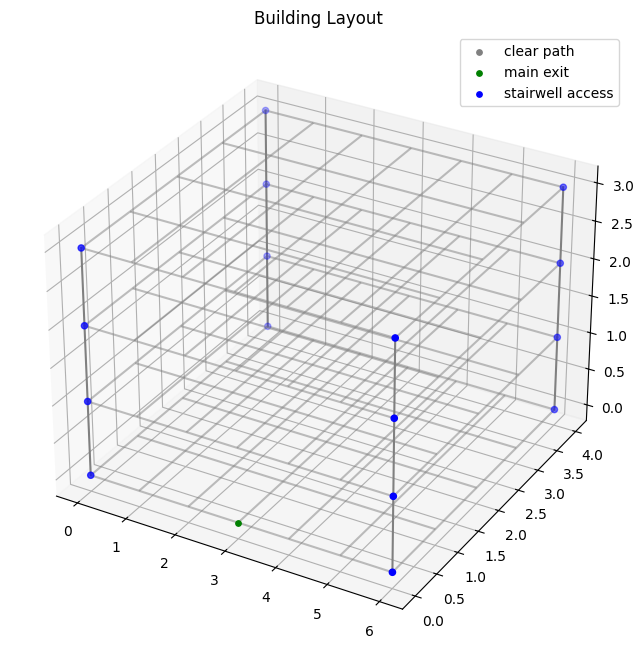

In [ ]:
def grid_3Dlayout(L,W,H):
  #building dimensions
  x_range = np.arange(L)
  y_range = np.arange(W)
  z_range = np.arange(H)
  #makign the 3D grid
  X, Y, Z = np.meshgrid(x_range, y_range, z_range)
  fig = plt.figure(figsize=(8,8))
  ax = plt.axes(projection='3d')
  #adding the connections to each node(edges) using wireframe
  for k in range(H):
    ax.plot_wireframe(X[:,:,k], Y[:,:,k], Z[:,:,k], color='grey', alpha=0.5)
  #adding the starwell nodes on all four corners
  corner_x = [0, L-1, 0, L-1]
  corner_y = [0, 0, W-1, W-1]
  stairwell_coords = []
  for k in range(H):
      for i in range(len(corner_x)):
          stairwell_coords.append((corner_x[i], corner_y[i], k))
  #initializing the main exit's location
  main_exit_x = L // 2
  main_exit_y = 0
  main_exit_z = 0
  main_exit_coord = (main_exit_x, main_exit_y, main_exit_z)
  #collecting coordinates of all safe nodes (excluding the exit/stairwell)
  safe_x, safe_y, safe_z = [], [], []
  for x in x_range:
      for y in y_range:
          for z in z_range:
              if (x, y, z) != stairwell_coords and (x, y, z) != main_exit_coord:
                  safe_x.append(x)
                  safe_y.append(y)
                  safe_z.append(z)
  #plotting stairwell coords
  for k in range(H):
    ax.scatter(corner_x, corner_y, [k]*4, color='blue', s=20)
  #connecting the stairwells vertically
  for k in range(H - 1):
    for i in range(len(corner_x)):
      ax.plot([corner_x[i], corner_x[i]], [corner_y[i], corner_y[i]], [k, k+1], color='grey', linestyle='-')
  #legend markers
  ax.scatter([], [], [], color='grey', s=15, label='clear path')
  ax.scatter(main_exit_x, main_exit_y, main_exit_z, color='green', s=15, label='main exit')
  ax.scatter([], [], [], color='blue', s=15, label='stairwell access')
  ax.set_title("Building Layout")
  ax.legend()
#dimensions
length = 7
width = 5
height = 4

grid_3Dlayout(length,width,height)

**character and fire positions**

In [ ]:
from matplotlib.artist import get
# helper to pick rand coord on highest layer
def get_starting_position(grid, stairwell_coords, fire_coord):
    L, W, H = grid.shape
    # Want character to start on random coord on highest layer and not on stairway/fire coord
    highest_layer = H - 1

    # iterate over every x,y coord on highest layer
    possible_starts = [(x, y, highest_layer)
                        for x in range(L)
                        for y in range(W)
                        if (x, y, highest_layer) not in stairwell_coords
                        and (x, y, highest_layer) != fire_coord
                        and grid[x, y, highest_layer] == 0]

    if not possible_starts:
        return None

    start = random.choice(possible_starts)
    return start


def initializing_fire_charcter(L,W,H, stairwell_coords, main_exit_coord):
  grid = np.zeros((L, W, H), dtype=int)
  #get all the grids coords
  grid_coords =[(x,y,z) for x in range(L) for y in range(W) for z in range(H)]
  #from the grid_coords exclude stairwell/main exit nodes
  available_coords = [coord for coord in grid_coords if coord not in stairwell_coords and coord != main_exit_coord]
  #possible location the fire can spawn - only upper floors
  possible_fire_coords = [coord for coord in available_coords if coord[2]>0]
  #randomly choose fires starting position
  fire_initial_coord = possible_fire_coords[np.random.randint(len(possible_fire_coords))]
  #possible location the character can spawn - not the same node as the fire
  character_initial_coord = get_starting_position(grid, stairwell_coords, fire_initial_coord)
  #possible_character_coords[np.random.randint(len(possible_character_coords))]

  return fire_initial_coord, character_initial_coord

**array to store the fires state**

In [ ]:
def fire_state(L, W, H, fire_initial_coord):
  #initialzing the grid as all 0 (no fire present)
  fire_state = np.zeros((L, W, H))
  #mark the fires starting position as 2(fire present)
  fire_state[fire_initial_coord] = 2

  return fire_state

**fire is catching**

In [ ]:
def fire_spreading(fire_state, character_coords, slow_spread_rate=0.03, fast_spread_rate=0.06):
  #building dimensions
  L, W, H = fire_state.shape
  #copy of the grid to update safely
  updated_fire_state = fire_state.copy()
  #identify current fire/smoke coords
  fire_coords = np.argwhere(fire_state == 2)
  smoke_coords = np.argwhere(fire_state == 1)
  #smoke created from nearby fire node
  for (fx, fy, fz) in fire_coords:
    #checking all adjacent nodes
    for dx in [-1, 0, 1]:
      for dy in [-1, 0, 1]:
        for dz in [-1, 0, 1]:
          if (dx, dy, dz) == (0, 0, 0):
            continue
          nx, ny, nz = fx + dx, fy + dy, fz + dz
          #makes sure the coords are within bounds
          if 0 <= nx < L and 0 <= ny < W and 0 <= nz < H:
            #spread smoke into nearby safe nodes
            if updated_fire_state[nx, ny, nz] == 0:
              #check the location of the character if character is in proximity
              character_prox = abs(character_coords[2] - nz) <= 1
              #nearby: spread slowly, far: spread quickly
              current_spread_rate = slow_spread_rate if character_prox else fast_spread_rate
              #depending on the current spread rate it randomly decides the safe nodes as smoke
              if np.random.rand() < current_spread_rate:
                updated_fire_state[nx, ny, nz] = 1
  #smoke changes to fire
  smoke_coords_updated = np.argwhere(updated_fire_state == 1)
  for (sx, sy, sz) in smoke_coords_updated:
      #checking all adjacent nodes
      for dx in [-1, 0, 1]:
          for dy in [-1, 0, 1]:
              for dz in [-1, 0, 1]:
                  if (dx, dy, dz) == (0, 0, 0):
                      continue
                  nx, ny, nz = sx + dx, sy + dy, sz + dz
                  #coords are within the grid bounds
                  if 0 <= nx < L and 0 <= ny < W and 0 <= nz < H:
                      #fire spreads if the node is smoke
                      if updated_fire_state[nx, ny, nz] == 1:
                          #check the location of the character if character is in proximity
                          character_prox = abs(character_coords[2] - sz) <= 1
                          #nearby: spread slowly, far: spread quickly
                          current_spread_rate = slow_spread_rate if character_prox else fast_spread_rate
                          #depending on the current spread rate it randomly decides the smoke nodes as fire
                          if np.random.rand() < current_spread_rate:
                              updated_fire_state[nx, ny, nz] = 2

  return updated_fire_state

**Cost**

In [ ]:
def get_movement_cost(node_state):
  #safe nodes(0): no penalty
  if node_state == 0:
    return 1
  #smoke nodes(1): mild penalty
  elif node_state == 1:
    return 5
  #fire nodes(2): high penalty
  elif node_state == 2:
    return 20

**Implementation of A Star and BFS**

Current, algorithms find random valid spot on highest level. Does algorithm to stairway, only goes down on stairway. then continues until it reaches layer one where goal node is no longer stairwell but instead is main exit.

stil need to account for dyanmic spread, smoke penalties, and if current stairway down is continuoable

**Implement Cost Function to both A star and UCS**

- integrate the cost function into the algorithms so that each potential step to calculate the total cost of a path

- also integrate it to the metric collection function, the "danger exposure: metric should consider how much risk the character took - iterating through the path found by the algorithm and summing up the penalties

In [ ]:
from math import cos
import heapq
import numpy as np
import random

# Creates a fire spread simulation over time
def precompute_fire_spread(initial_fire, steps=50, character_path=None, slow_spread_rate=0.03, fast_spread_rate=0.06):
    # Copy initial fire coordinates
    fire_timeline = [initial_fire.copy()]
    # Initialize current with starting fire grid
    current_fire = initial_fire.copy()

    # Loop throguh each step in simulation minus start
    for i in range(1, steps):
        # If a character path was provided and current step is within range, use current postion at step
        if character_path and i < len(character_path):
            char_pos = character_path[i]
        else:
            # Else, use last known position or default if no path given
            char_pos = character_path[-1] if character_path else (0, 0, 0)

        #Update fire grid with firespreading function based on current char position
        current_fire = fire_spreading(current_fire, char_pos, slow_spread_rate, fast_spread_rate)
        #  add new fire state to timeline, continue loop
        fire_timeline.append(current_fire.copy())
    #return full list of fire states (one per step)
    return fire_timeline

# UCS Implementation
def ucs_3d(grid, stairwell_coords, main_exit_coord, fire_timeline):
    # Initialize grid layout, start, and initial fire coords
    L, W, H = grid.shape
    fire_coord, start = initializing_fire_charcter(L, W, H, stairwell_coords, main_exit_coord)

    # Define possible layer movements (8 directions)
    directions = [(dx, dy, 0)
                  for dx in [-1, 0, 1]
                  for dy in [-1, 0, 1]
                  if not (dx == 0 and dy == 0)]

    # Store complete path the character takes through simulation
    full_path = []
    # Dict to store movement cost at each step
    step_costs = {}

    #Initialize  current position (start), starting layer (highest), previous stair (for vertical movement), step index (for timeline)
    current_pos = start
    current_layer = H - 1
    previous_stair = None
    step_idx = 0

    # If current layer is not layer 0, continue going down
    while current_layer >= 0:
        # Get current fire grid based on step index
        fire_grid = fire_timeline[min(step_idx, len(fire_timeline) - 1)]

        # if on layer 0, goal node is main exit coordinates
        if current_layer == 0:
            goal = main_exit_coord
        # else, pick a stairwell on layer as goal to next floor; Stairway can't be on same (x,y) as previous stair
        else:
            candidates = [(x, y, z) for x, y, z in stairwell_coords
                         if z == current_layer and (not previous_stair or (x, y) != (previous_stair[0], previous_stair[1]))]
            # pick candidate based on one surrounded by lowest total fire cost
            # sum of movement costs for neighbors in 3x3 region around the candidates
            if candidates:
               goal = min(
                candidates,
                key=lambda c: sum(get_movement_cost(fire_grid[nx, ny, nz])
                                  for nx in range(c[0]-1, c[0]+2)
                                  for ny in range(c[1]-1, c[1]+2)
                                  for nz in [c[2]]
                                  if 0 <= nx < L and 0 <= ny < W))
        # priority queue initialization with current position and zero cost
        frontier = []
        heapq.heappush(frontier, (0, current_pos))
        # Record best kown cost to each node, intialized to infinity by default
        cost_so_far = np.full(grid.shape, np.inf)
        cost_so_far[current_pos] = 0
        # Define parent nodes for path reconstruction
        parent = {}
        # Track explored nodes
        visited = np.zeros_like(grid, dtype=bool)
        # Track initial movement cost for starting position
        step_costs[current_pos] = get_movement_cost(fire_grid[current_pos])

        # Main loop
        while frontier:
            # if frontier empty, break loop
            if frontier == []:
              break
            # Heapq pops lowest costing node
            current_cost, (x, y, z) = heapq.heappop(frontier)

            # if visited already, skip
            if visited[x, y, z]:
                continue
            visited[x, y, z] = True

            # If node is goal, stop the loop
            if (x, y, z) == goal:
                break

            #Get fire grid (firespread) for current timestamp
            fire_grid = fire_timeline[min(step_idx, len(fire_timeline) - 1)]
            # Explore all valid neighbors in same layer
            for dx, dy, dz in directions:
                nx, ny, nz = x + dx, y + dy, z
                # check within layers
                if 0 <= nx < L and 0 <= ny < W and nz == current_layer:
                    # get the move cost of the neighboring nodes
                    move_cost = get_movement_cost(fire_grid[nx, ny, nz])
                    new_cost = current_cost + move_cost

                    # update cost if this path is cheaper
                    if new_cost < cost_so_far[nx, ny, nz]:
                        cost_so_far[nx, ny, nz] = new_cost
                        parent[(nx, ny, nz)] = (x, y, z)
                        step_costs[(nx, ny, nz)] = move_cost
                        heapq.heappush(frontier, (new_cost, (nx, ny, nz)))

        # local path for layer. Backtrack using parents and reverse
        local_path = [goal]
        while local_path[-1] in parent:
            local_path.append(parent[local_path[-1]])
        local_path.reverse()

        # append each step in character path to full path of whole simulation
        # and cost of each step
        for node in local_path[1:]:
          full_path.append(node)
          step_costs[node] = get_movement_cost(fire_grid[node])
          # Sync path with fire timeline
          step_idx += 1

        if current_layer == 0:
            break
        # Handle Stairway Movement
        # define coord of stairway of current layer - 1
        down_stair = (goal[0], goal[1], current_layer - 1)
        # add vertical movement in full path
        full_path.append(down_stair)
        # Get cost of stairway at current fire grid
        step_costs[down_stair] = get_movement_cost(fire_grid[down_stair])
        step_idx += 1
        # prevents algorithm from choosing same stairwell
        previous_stair = goal
        # update new "start" position of layer
        current_pos = down_stair
        current_layer -= 1

    # Update fire grid of final state in timeline. Get min of final step & last valid index of timeline list
    # if person within fire simulation, use correspondign state, if path longer than timeline use last known fire firegrid (account for out of range)
    fire_grid = fire_timeline[min(step_idx, len(fire_timeline) - 1)]
    # list of all movemnet cost for total sum
    path_step_costs = [step_costs.get(p, get_movement_cost(fire_grid[p])) for p in full_path]
    total_cost = sum(path_step_costs)

    # return entire path, total movement cost (danger exposure), path step costs to show which nodes taken, and fire start coordinates
    return full_path, total_cost, path_step_costs, fire_coord

# A* Implementation
# Heuristics - Manhattan Distance + Penalty
def heuristics(a, b, fire_grid):
    # Manhattan distance alg for 3d
    manhattan = abs(a[0]-b[0]) + abs(a[1]-b[1]) + abs(a[2]-b[2])
    # look up fire state at current node coord
    node_state = fire_grid[a[0], a[1], a[2]]

    # return additional penalty to emphasize the cost
    if node_state == 2:
        return 1000
    elif node_state == 1:
        return manhattan + 100
    else:
        return manhattan


def a_star_3d(grid, stairwell_coords, main_exit_coord, fire_timeline):
    # Initialize starting grid, starting coord and initial fire coords
    L, W, H = grid.shape
    fire_coord, start = initializing_fire_charcter(L, W, H, stairwell_coords, main_exit_coord)

    # direction moves on xy layer
    directions = [(dx, dy)
                  for dx in [-1, 0, 1]
                  for dy in [-1, 0, 1]
                  if not (dx == 0 and dy == 0)]
    # Accumulated path from whole 3d simulation
    full_path = []
    # Keep track of movement cost for each step
    step_costs = {}
    # set current position to starting initially
    current_pos = start
    # Start on highest layer
    current_layer = H - 1
    # track whcih stairway used previously to avoid looping
    previous_stair = None
    # keep track of total number of steps for fire spread timeline
    step_idx = 0

    # Continue alg search until reach layer 0
    while current_layer >= 0:
      # get current fire grid state based on step index
      fire_grid = fire_timeline[min(step_idx, len(fire_timeline) - 1)]

      # if on layer 0, goal is main exit coordinate
      if current_layer == 0:
        goal = main_exit_coord
      else:
        # else, pick a stairway on current layer
        candidates = [(x, y, z) for x, y, z in stairwell_coords
                     if z == current_layer and (not previous_stair or (x, y) != (previous_stair[0], previous_stair[1]))]
        # pick candidate surrounded by least fire cost
        if candidates:
              goal = min(
                candidates,
                key=lambda c: sum(get_movement_cost(fire_grid[nx, ny, nz])
                                  for nx in range(c[0]-1, c[0]+2)
                                  for ny in range(c[1]-1, c[1]+2)
                                  for nz in [c[2]]
                                  if 0 <= nx < L and 0 <= ny < W))

      # initialize frontier with initial start
      frontier = []
      heapq.heappush(frontier, (0, current_pos))
      # Store path for later reconstruction
      came_from = {}
      # intialize g(n) cost from start to node
      g_score = np.full(grid.shape, np.inf)
      # cost to reach the starting position = 0
      g_score[current_pos] = 0
      # intialize f score (estimated total cost)
      f_score = np.full(grid.shape, np.inf)
      # starting coordinates f score with heuristic (start to goal while considering fire states)
      f_score[current_pos] = heuristics(current_pos, goal, fire_grid)
      # record movement cost for start
      step_costs[current_pos] = get_movement_cost(fire_grid[current_pos])
      # track whcih nodes have been visited
      visited = np.zeros_like(grid, dtype=bool)
      exit_found = None

      # Main Loop
      while frontier:
          # check if frontier empty
          if frontier == []:
            break
          # pop node with lowest f score (best est. total cost)
          _, current = heapq.heappop(frontier)
          x, y, z = current

          # skip nodes already explored
          if visited[x, y, z]:
            continue
          visited[x, y, z] = True

          # if character reaches stair or exit, stop
          if current == goal:
              exit_found = current
              break
          #update fire grid baset on step index
          fire_grid = fire_timeline[min(step_idx, len(fire_timeline) - 1)]
          #check possible moves in neighbors
          for dx, dy in directions:
              nx, ny, nz = x + dx, y + dy, z
              # maintain moves within grid bounds and layer
              if 0 <= nx < L and 0 <= ny < W and nz == current_layer:
                  # calculate cost of moving to neighbor node
                  move_cost = get_movement_cost(fire_grid[nx, ny, nz])
                  # the cost so far if we go through this neighbor
                  tentative_g = g_score[x, y, z] + move_cost
                  # if path to neighbor cheaper, use it
                  if tentative_g < g_score[nx, ny, nz]:
                      came_from[(nx, ny, nz)] = current
                      g_score[nx, ny, nz] = tentative_g
                      f_score[nx, ny, nz] = tentative_g + heuristics((nx, ny, nz), goal, fire_grid)
                      step_costs[(nx, ny, nz)] = move_cost
                      heapq.heappush(frontier, (f_score[nx, ny, nz], (nx, ny, nz)))
      # break if no exit found
      if exit_found is None:
          break
      # build local path from goal back to start on layer
      local_path = [goal]
      while local_path[-1] in came_from:
          local_path.append(came_from[local_path[-1]])
      # organize path from start to goal
      local_path.reverse()

      # add layer path to total full path
      for node in local_path[1:]:
          full_path.append(node)
          step_costs[node] = get_movement_cost(fire_grid[node])
          #increase step index to properly add cost
          step_idx += 1
      # if on ground level, exit
      if current_layer == 0:
          break
      # else, move down stairs one layer
      down_stair = (goal[0], goal[1], current_layer - 1)
      # add stair movement to full path
      full_path.append(down_stair)
      # log movement cost of going down stairs
      step_costs[down_stair] = get_movement_cost(fire_grid[down_stair])
      step_idx += 1
      # Prevent reusing stair
      previous_stair = goal
      # new "starting" coord of next floor
      current_pos = down_stair
      #Move down layer
      current_layer -= 1

    # final fire state of timeline
    fire_grid = fire_timeline[min(step_idx, len(fire_timeline) - 1)]
    path_step_costs = [step_costs.get(p, get_movement_cost(fire_grid[p])) for p in full_path]
    total_cost = sum(path_step_costs)

    return full_path, total_cost, path_step_costs, fire_coord

In [ ]:
#needs to be relocated but leave here to see the animaiton fo the fire
def animate_fire_spreading(L, W, H, fire_timeline, character_path, stairwell_coords, main_exit_coord):
    #0: clear, 1: smoke, 2: fire
    #grid setup
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    #building dimensions
    x_range = np.arange(L)
    y_range = np.arange(W)
    z_range = np.arange(H)
    #making the 3D grid
    X, Y, Z = np.meshgrid(x_range, y_range, z_range)

    # get max of either full path or fire spread to ensure enough frames, cap at 50
    num_frames = min(max(len(character_path), len(fire_timeline)), 50)

    #animation updates
    def update(frame):
        ax.clear()
        ax.set_xlabel("length")
        ax.set_ylabel("width")
        ax.set_zlabel("height")
        ax.set_title(f"Building on Fire")

        # get enough frames for animation of fire spread
        fire_grid = fire_timeline[min(frame, len(fire_timeline) - 1)]

        # set carrents current coordinate for corresponding animation  frame
        character_coords = character_path[min(frame, len(character_path) - 1)]

        #building edges
        for k in range(H):
            ax.plot_wireframe(X[:,:,k], Y[:,:,k], Z[:,:,k], color='grey', alpha=0.5)
        #fire spread simulation one step

        #compute clear paths
        safe_x, safe_y, safe_z = [], [], []
        for x in x_range:
            for y in y_range:
                for z in z_range:
                    if (x, y, z) not in stairwell_coords and (x, y, z) != main_exit_coord and fire_grid[x, y, z] == 0 and (x, y, z) != character_coords:
                        safe_x.append(x)
                        safe_y.append(y)
                        safe_z.append(z)
        ax.scatter(safe_x, safe_y, safe_z, color='grey', s=15, label='clear path')
        #stairwell logic
        stair_x = [c[0] for c in stairwell_coords]
        stair_y = [c[1] for c in stairwell_coords]
        stair_z = [c[2] for c in stairwell_coords]
        ax.scatter(stair_x, stair_y, stair_z, color='blue', s=15)

        # Connecting the stairwells vertically
        corner_x = [0, L-1, 0, L-1]
        corner_y = [0, 0, W-1, W-1]
        for k in range(H - 1):
            for i in range(len(corner_x)):
                ax.plot([corner_x[i], corner_x[i]], [corner_y[i], corner_y[i]], [k, k+1], color='grey', linestyle='-')
        #plot character
        ax.scatter(character_coords[0], character_coords[1], character_coords[2], color='purple', s=15, label='character')

        #plot the path as it goes
        path_so_far = character_path[:frame+1]
        if path_so_far:
            path_x = [c[0] for c in path_so_far]
            path_y = [c[1] for c in path_so_far]
            path_z = [c[2] for c in path_so_far]
            ax.plot(path_x, path_y, path_z, color='purple', linewidth=2, alpha=0.7, label='character path')

        #plot smoke(yellow) and fire(red)
        fire_x, fire_y, fire_z = np.where(fire_grid == 2)
        smoke_x, smoke_y, smoke_z = np.where(fire_grid == 1)
        ax.scatter(smoke_x, smoke_y, smoke_z, color='orange', s=15, label='smoke present')
        ax.scatter(fire_x, fire_y, fire_z, color='red', s=15, label='fire zone')
        ax.legend()
    #animate for fixed number of frames
    ani = animation.FuncAnimation(fig, update, frames=num_frames, repeat=False)
    plt.close(fig)
    return ani

**Metric Collection**

In [ ]:
import pandas as pd
import os
# Collect metrics for one run, metric collection activates methods
def metric_collection(grid, stairwell_coords, main_exit_coord, method, fire_timeline, trial_num, seed):
  # Start timer as soon as algorithm is called
  start_time = time.time()
  #run the method and gather the path, total cost, each step costs, and the initial fire coords
  path, total_cost, step_costs, fire_coord = method(grid, stairwell_coords, main_exit_coord, fire_timeline)
  # elapsed tie
  time_taken = time.time() - start_time

  # Account for any issues with path and return default
  if path is None:
    return {
        'Trial': trial_num,
        'Seed': seed,
        'time_taken': time_taken,
        'success': False,
        'steps_taken': 0,
        'danger_exposure': 0,
        'Safety Nodes': 0,
        'Smoke Nodes': 0,
        'Fire Nodes'
        'step_costs': [],
        'path': []
    }
  saftey_nodes = step_costs.count(1)
  smoke_nodes = step_costs.count(5)
  fire_nodes = step_costs.count(20)
  # when there is a sucessfull run, return total time taken, sucess true, steps taken -1 (to avoid start), total cost (movement cost of all steps), step cost (cost of each step made), path (coordinates taken in route)
  return {
      'Trial': trial_num,
      'Seed': seed,
      'time_taken': time_taken,
      'success': True,
      'steps_taken': len(path) - 1,
      'danger_exposure': total_cost,
      'Safety Nodes': saftey_nodes,
      'Smoke Nodes': smoke_nodes,
      'Fire Nodes': fire_nodes,
      'step_costs': step_costs,
      'path': path
  }, fire_coord

def metrics_csv(results, algorithm, trial_num, seed):
  current_metrics = results.copy()
  current_metrics['step_costs'] = ', '.join(map(str, current_metrics.get('step_costs', [])))
  current_metrics['path'] = ', '.join(map(str, current_metrics.get('path', [])))

  df = pd.DataFrame([current_metrics])
  if os.path.exists(f'{algorithm}_metrics.csv'):
    df.to_csv(f'{algorithm}_metrics.csv', mode='a', header=False, index=False)
  else:
      df.to_csv(f'{algorithm}_metrics.csv', index=False)

# get average of each important column to determine better algorithm
def average_metrics(ucs_csv, a_star_csv):
    # read csv file into dataframe
    ucs_df = pd.read_csv(ucs_csv)
    a_star_df = pd.read_csv(a_star_csv)

    #strip to avoid any unwanted
    ucs_df.columns = ucs_df.columns.str.strip()
    a_star_df.columns = a_star_df.columns.str.strip()

    # turn sucess into integers to get int sucess rate
    ucs_df['success'] = ucs_df['success'].astype(int)
    a_star_df['success'] = a_star_df['success'].astype(int)

    #gather average for ucs
    ucs_average = pd.Series({
        'time_taken': ucs_df['time_taken'].mean(),
        'success': ucs_df['success'].mean(),
        'steps_taken': ucs_df['steps_taken'].mean(),
        'danger_exposure': ucs_df['danger_exposure'].mean()
    })

    # get avg for astar
    a_star_average = pd.Series({
        'time_taken': a_star_df['time_taken'].mean(),
        'success': a_star_df['success'].mean(),
        'steps_taken': a_star_df['steps_taken'].mean(),
        'danger_exposure': a_star_df['danger_exposure'].mean()
    })

    # Compare numerical columns (time, steps taken and danger cost) and assign winner for better  (less)
    winner = {}
    for col in ['time_taken', 'steps_taken', 'danger_exposure']:
        if ucs_average[col] < a_star_average[col]:
            winner[col] = 'UCS'
        elif ucs_average[col] > a_star_average[col]:
            winner[col] = 'A Star'
        else:
            winner[col] = 'Tie'
    # compare sucess rate (more = better)
    if ucs_average['success'] > a_star_average['success']:
        winner['success'] = 'UCS'
    elif a_star_average['success'] > ucs_average['success']:
        winner['success'] = 'A*'
    else:
        winner['success'] = 'Tie'

    # summary of averages and display winner table
    summary_df = pd.DataFrame({
        'UCS_avg': ucs_average,
        'A_star_avg': a_star_average,
        'Winner': pd.Series(winner)
    })
    # count how many UCS/Astar wins, determine who had more = winner
    ucs_wins = sum(v == "UCS" for v in winner.values())
    astar_wins = sum(v == "A Star" for v in winner.values())
    if ucs_wins > astar_wins:
        overall_winner = "UCS"
    elif astar_wins > ucs_wins:
        overall_winner = "A Star"
    else:
        overall_winner = "Tie"

    return summary_df, overall_winner


In [ ]:
import numpy as np
import random
import heapq

base = 42
seeds = [(base + i * 137) % 10_000 for i in range(10)]
for trial_num, SEED in enumerate(seeds, start = 1):
  L, W, H = 12, 9, 6
  grid = np.zeros((L, W, H), dtype=int)
  stairwell_coords = [(0, 0, z) for z in range(H)] + [(0, W-1, z) for z in range(H)] + \
                     [(L-1, 0, z) for z in range(H)] + [(L-1, W-1, z) for z in range(H)]
  main_exit_coord = (L // 2, 0, 0)

  #seeds
  random.seed(SEED); np.random.seed(SEED)
  fire_coord, start = initializing_fire_charcter(L, W, H, stairwell_coords, main_exit_coord)
  initial_fire = fire_state(L, W, H, fire_coord)
  random.seed(SEED); np.random.seed(SEED)
  fire_timeline = precompute_fire_spread(initial_fire, steps=50)

  #UCS
  ucs_metrics, _ = metric_collection(grid, stairwell_coords, main_exit_coord, ucs_3d, fire_timeline, trial_num, SEED)
  metrics_csv(ucs_metrics, 'UCS', trial_num, SEED)

  #A Star
  a_star_metrics, _ = metric_collection(grid, stairwell_coords, main_exit_coord, a_star_3d, fire_timeline, trial_num, SEED)
  metrics_csv(a_star_metrics, 'A_Star', trial_num, SEED)

#uncomment once the metrics are saved
# summary, overall_winner = average_metrics('UCS_metrics.csv', 'A_Star_metrics.csv')
# print("Average Metrics Summary:")
# print(summary)
# print("Winner:", overall_winner)

  # Animations for one single run
'''
  fire_animation_ucs = animate_fire_spreading(
      L, W, H, fire_timeline, ucs_metrics['path'], stairwell_coords, main_exit_coord)

  fire_animation_a_star = animate_fire_spreading(
      L, W, H, fire_timeline, a_star_metrics['path'], stairwell_coords, main_exit_coord)


  display(HTML(fire_animation_ucs.to_jshtml()))

  display(HTML(fire_animation_a_star.to_jshtml()))
  '''

Average Metrics Summary:
                    UCS_avg  A_star_avg  Winner
danger_exposure  186.200000  202.900000     UCS
steps_taken       53.000000   53.700000     UCS
success            1.000000    1.000000     Tie
time_taken         0.003582    0.002787  A Star
Winner: UCS


"\n  fire_animation_ucs = animate_fire_spreading(\n      L, W, H, fire_timeline, ucs_metrics['path'], stairwell_coords, main_exit_coord)\n\n  fire_animation_a_star = animate_fire_spreading(\n      L, W, H, fire_timeline, a_star_metrics['path'], stairwell_coords, main_exit_coord)\n\n\n  display(HTML(fire_animation_ucs.to_jshtml()))\n\n  display(HTML(fire_animation_a_star.to_jshtml()))\n  "